In [1]:
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml import feature, evaluation, Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
conf = (SparkConf()
            .setAppName('data_explore')
            .setMaster('spark://spark-master:7077')
       )
conf.set("spark.executor.memory", "6g")
conf.set("spark.driver.maxResultSize", "0")
conf.set("spark.sql.shuffle.partitions", "100")
# conf.set("spark.default.parallelism", "3")
conf.set("spark.driver.memory", "3g") 

# TODO
+ validation/model tuning
+ cross validation
+ test final model against this dataset: https://github.com/hunters-forge/mordor

---


In [3]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [4]:
spark.sparkContext.getConf().getAll()

[('spark.executor.id', 'driver'),
 ('spark.sql.shuffle.partitions', '100'),
 ('spark.executor.memory', '6g'),
 ('spark.driver.host', '7b97f6eeabc6'),
 ('spark.driver.memory', '3g'),
 ('spark.app.id', 'app-20191109045930-0030'),
 ('spark.rdd.compress', 'True'),
 ('spark.master', 'spark://spark-master:7077'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.port', '45013'),
 ('spark.driver.maxResultSize', '0'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'data_explore')]

In [15]:
df = (spark.read.format('csv')
      .option('inferSchema', 'true')
      .option('header', 'true')
      .option('escape', '"')
#       .option('schema', T.StringType())
      .load('hdfs://namenode:9000/data/labeled_process_logs.csv') 
      .dropna() # orginal dataset had 52,025 rows, this operation drops 682 rows
     )
df.cache()

DataFrame[timestamp: string, hostname: string, kernel: string, host_platform: string, process_name: string, parent_process: string, login_id: string, event_id: int, command_line: string, class_label: int]

# Data Cleaning and Engineering

---


## the target labels are unbalanced, and will result in a model with high bias that won't generalize well.  the minority class (1) will be resampled

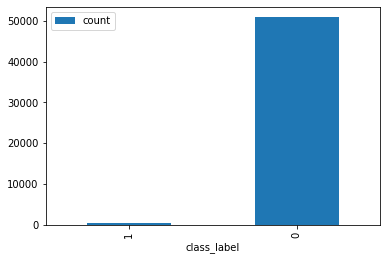

In [6]:
df.groupBy('class_label').count().toPandas().plot.bar(x='class_label', y='count')

In [7]:
df.groupBy('class_label').count().show()

+-----------+-----+
|class_label|count|
+-----------+-----+
|          1|  452|
|          0|50891|
+-----------+-----+



In [8]:
bootstrapped_1_rdd = spark.sparkContext.union([df.filter('class_label == 1').sample(withReplacement=True, fraction=.1, seed=0).rdd
                  for x in range(1000)])
bootstrapped_1_rdd.persist()
bootstrapped_1_df = spark.createDataFrame(bootstrapped_1_rdd)
bootstrapped_1_df.cache()

In [16]:
combined_df = spark.createDataFrame(spark.sparkContext.union([bootstrapped_1_df.rdd, df.rdd]))

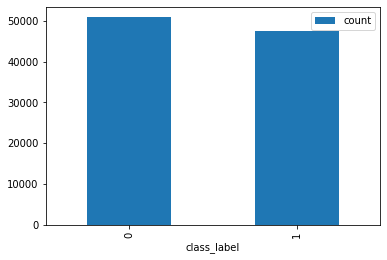

In [17]:
combined_df.groupBy('class_label').count().toPandas().plot.bar(x='class_label', y='count')

### Clean process,path fields and create command line tokens

In [18]:
# TODO: consider converting this to a UDF

from pyspark.sql.functions import regexp_extract, regexp_replace, col, count, split, size, to_date
combined_df = combined_df.select(
    '*',
    regexp_extract(col('process_name'), r"(\w?:?.*\\?\w+\s?\w+\\)", 0).alias('process_path'),
    split(col('command_line'), '\s+(?=[-/]+)').alias('cmd_line_split')
).withColumn(
    'class_label', (col('class_label').cast('int'))
).withColumn(
    'trusted_path', (col('process_path').like('%C:\Program Files%') | col('process_path').like('%C:\Windows%') | col('process_path').like('%C:\PROGRA~2%') |col('process_path').like('%Program Files (x86)%')).cast('int')
).withColumn(
    '_timestamp', F.to_timestamp(col('timestamp'))
).withColumn(
    'process_name', regexp_extract(col('process_name'), r'(\w+.?\w+$)', 0)
).withColumn(
    'parent_process', regexp_extract(col('parent_process'), r'(\w+.?\w+$)', 0)
).withColumn(
    'command_line', regexp_replace(col('command_line'), r'[:\\"\?]'," ")  # directory punct
).withColumn(
    'command_line', regexp_replace(col('command_line'), r'--field-trial-handle=.*\d+',"")   # chrome data
).withColumn(
    'command_line', regexp_replace(col('command_line'), r'\/\/raw.*\.com(\/\w+)*.*\/',"") # github url
).withColumn(
    'command_line', regexp_replace(col('command_line'), r"\||\s*\"\s*\|\"|-\s*\d{1}\s*|\'","")  # | " 1 ' , 
).withColumn(
    'command_line', regexp_replace(col('command_line'), r':\/\/(\d+\.?)+:\d+',"")  # ip 
).withColumn(
    'command_line', regexp_replace(col('command_line'), r'\b\d+\b',"")  # lone numbers
).withColumn(
    'command_line', regexp_replace(col('command_line'), r'\{.*\}',"")  # {edfc6dbe, 9c3, 3ed, 21a1affb5fd}
).withColumn(
    'command_line', regexp_replace(col('command_line'), r'[=/;\(\),_]',"") # random punctuation
).withColumn(
    'cmd_line_tokens', split(col('command_line'), '\s+')
)

### Cleaned command line tokens

In [19]:
@F.udf(returnType=T.ArrayType(T.StringType()))
def clean_array(l):
    arr = [str(x).lower() for x in l if x != 'C' and x != ""]
    return arr

In [20]:
combined_df = combined_df.withColumn('cmd_line_tokens', clean_array(col('cmd_line_tokens')))

In [21]:
combined_df.select('cmd_line_tokens').sample(.10).show(20, False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|cmd_line_tokens                                                                                                                                                                                                         |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[powershell.exe, -executionpolicy, bypass, -c, $exe, get-itemproperty, -path, hklm, system, currentcontrolset, services, walletservice, .imagepath.split[]$path, resolve-path, $exe.pathif, test-path, $path, +, .saved]|
|[powershell.exe, -executionpolicy, bypass, -c, gpresult, r]                                                                

### Create train, validation, test split

In [22]:
training_df, validation_df, testing_df = combined_df.select('cmd_line_tokens', 'class_label').randomSplit([0.6, 0.3, 0.1], seed=0)

In [23]:
[training_df.count(), validation_df.count(), testing_df.count()]

[58973, 29614, 9756]

### Create freq and tfidf pipeline and fit to training data

In [24]:
cv_pipeline = Pipeline(stages=[
    feature.CountVectorizer(minTF=1, minDF=3, inputCol='cmd_line_tokens', outputCol='tf')
]).fit(training_df)

In [25]:
cv_pipeline.transform(combined_df).select('tf').show(20,truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------+
|tf                                                                                                                                            |
+----------------------------------------------------------------------------------------------------------------------------------------------+
|(1087,[2,6,7,10,23,38,57,59,60,61,62,63,64,65,66,67,68,106,107],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|(1087,[14,36],[1.0,1.0])                                                                                                                      |
|(1087,[2,6,7,10,28,29],[1.0,1.0,1.0,1.0,1.0,1.0])                                                                                             |
|(1087,[11,12,27,40,42,43,44,45,46],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                                                        

In [26]:
len(cv_pipeline.stages[0].vocabulary)

1087

In [27]:
idf_pipeline = Pipeline(stages=[
    cv_pipeline, feature.IDF(inputCol='tf', outputCol='tfidf')
]).fit(training_df)

# Modeling
---

### create logistic regression model

In [28]:
lr = LogisticRegression(featuresCol='tfidf', labelCol='class_label')

In [ ]:
lr_pipeline = Pipeline(stages=[
    idf_pipeline, 
    lr
]).fit(training_df)

In [ ]:
lr_pipeline.transform(validation_df).\
    select(F.expr('float(prediction = class_label)').alias('correct')).\
    select(F.avg('correct')).show()

In [ ]:
import pandas as pd
vocabulary = idf_pipeline.stages[0].stages[0].vocabulary
weights = lr_pipeline.stages[-1].coefficients.toArray()
coeffs_df = pd.DataFrame({'token': vocabulary, 'weight': weights})

### Inference

In [ ]:
validation_model = en_lr.transform(validation_df)

### The positive class is 1 (malicious) so the positive weights indicate a feature that contributes positively to being classified as malicious

In [ ]:
coeffs_df.sort_values('weight', ascending=False).head(20)

### Example of malicious tokens

In [ ]:
training_df.select('cmd_line_tokens').filter('class_label == 1').sample(.20).show(15, truncate=False)

### The negative class is 0 (benign) so the negative weights indicate a feature that contributes negatively to being classified as benign

In [ ]:
coeffs_df.sort_values('weight').head(20)

### Example of benign tokens

In [ ]:
training_df.select('cmd_line_tokens').filter('class_label == 0').sample(.20).show(5, truncate=False)

### Create another model with elastic net regularization to control overfitting and mitigate noisy data
+ will grid search over these regParam and elasticNetParam parameters during validation

In [ ]:
en_lr = Pipeline(stages=[
    idf_pipeline,
    LogisticRegression(featuresCol='tfidf',labelCol='class_label',regParam=0.02,elasticNetParam=0.3)
]).fit(training_df)

In [ ]:
from pyspark.sql.functions import avg
validation_model.selectExpr('avg(float(prediction = class_label)) as prediction').show()

### Re-examine the coefficients of the model to determine how well it learned the weights for the tokens

In [ ]:
coefs = en_lr.stages[-1].coefficients.toArray()
word_coefs = pd.DataFrame({'token': cv_pipeline.stages[0].vocabulary, 'weights': coefs})

+ malicious tokens

In [ ]:
word_coefs.sort_values('weights', ascending=False).head(15)

+ benign tokens

In [ ]:
word_coefs.sort_values('weights', ascending=True).head(10)

# Model Tuning
+ Perform grid-search over TF-IDF and regularization parameters
---

In [ ]:
paramGrid = (ParamGridBuilder()
                 .baseOn({en_lr.labelCol: 'class_label'})
                 .baseOn({en_lr.predictionCol, 'prediction'}) 
                 .addGrid(en_lr.regParam, [0., 0.01, 0.02])
                 .addGrid(en_lr.elasticNetParam, [0., 0.2, 0.4])
                 .build()
            )

+ Loop over each parameter mapping in paramGrid and fit model

In [ ]:
models = []
for g in range(len(paramGrid)):
    print("Fitting model {}".format(g))
    _model = en_lr.fit(validation_df, paramGrid[g])
    models.append(_model)

+ Get the accuracy of each model

# Cross validation 
+ test generalization performance on test dataset

---

### Write LR intecept, coefficients, and CV vocabulary to disk

In [ ]:
en_lr.stages[1].intercept

In [ ]:
import pickle

with open('coefs_array.pkl', 'wb') as f:
    pickle.dump(coefs, f)
with open('intercept.pkl', 'wb') as f:
    pickle.dump(en_lr.stages[1].intercept, f)
with open('cv_vocabulary.pkl', 'wb') as f:
    pickle.dump(en_lr.stages[0].stages[0].stages[0].vocabulary, f)